### 1. Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#seed for reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Load data

In [4]:
import zipfile 
street_lights = "/content/drive/My Drive/streetlights.zip"
with zipfile.ZipFile(street_lights, 'r') as z:
    z.extractall()

In [5]:
#reading data
train_data = pd.read_csv('/content/Traffic_Train.csv')
test_data = pd.read_csv('/content/Test.csv')
train_path = '/content/Train'
test_path = '/content/Test'

In [6]:
train_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [7]:
paths = []
ids = []
for index, row in train_data.iterrows():
  Path = row[7]
  ClassId = row[6]
  Path = str(Path)
  ClassId =str(ClassId)
  ids.append(ClassId)
  paths.append(Path)

train_data['ClassId'] = ids
train_data['Path'] = paths

In [8]:
train_data['ClassId'] = train_data['ClassId'].astype('category')

In [9]:
train_data.isna().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

In [10]:
#creating train and test dataframe
#we will create dataframes and use keras Image data preprocessing function: flow_from_dataframe

# train
train_path = train_data.Path.values
train_labels = np.asarray(train_data['ClassId'].values)
train_dict = {'filepath': train_path, 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
#train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.astype('category')

# test
#test_names = test_data.ID.values
test_dict = {'filepath': test_data['Path'].values}
test = pd.DataFrame(data=test_dict)
#test['ID'] = test_data['ID']

In [11]:
train.head()

,filepath,LABEL
0,Train/20/00020_00000_00000.png,20
1,Train/20/00020_00000_00001.png,20
2,Train/20/00020_00000_00002.png,20
3,Train/20/00020_00000_00003.png,20
4,Train/20/00020_00000_00004.png,20


In [12]:
test.head()

,filepath
0,Test/00000.png
1,Test/00001.png
2,Test/00002.png
3,Test/00003.png
4,Test/00004.png


In [13]:
train.shape, test.shape

((39209, 2), (12630, 1))

### 3. EDA and Preprocessing

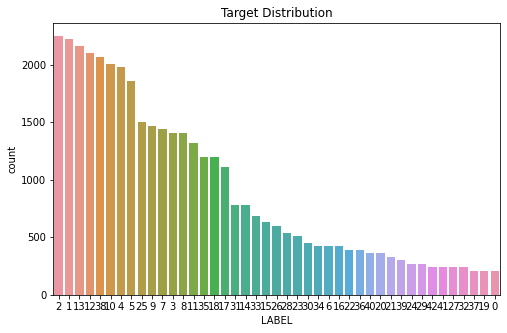

In [14]:
#visualizing target distribution 
f, ax = plt.subplots(1,1, figsize=(8,5))
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

In [15]:
# check proportions of each traffic label
train.LABEL.value_counts()/len(train)

2     0.057385
1     0.056620
13    0.055089
12    0.053559
38    0.052794
10    0.051264
4     0.050499
5     0.047438
25    0.038257
9     0.037491
7     0.036726
3     0.035961
8     0.035961
11    0.033666
35    0.030605
18    0.030605
17    0.028310
31    0.019893
14    0.019893
33    0.017572
15    0.016068
26    0.015303
28    0.013772
23    0.013007
30    0.011477
34    0.010712
6     0.010712
16    0.010712
22    0.009947
36    0.009947
40    0.009182
20    0.009182
21    0.008416
39    0.007651
24    0.006886
29    0.006886
42    0.006121
41    0.006121
27    0.006121
32    0.006121
37    0.005356
19    0.005356
0     0.005356
Name: LABEL, dtype: float64

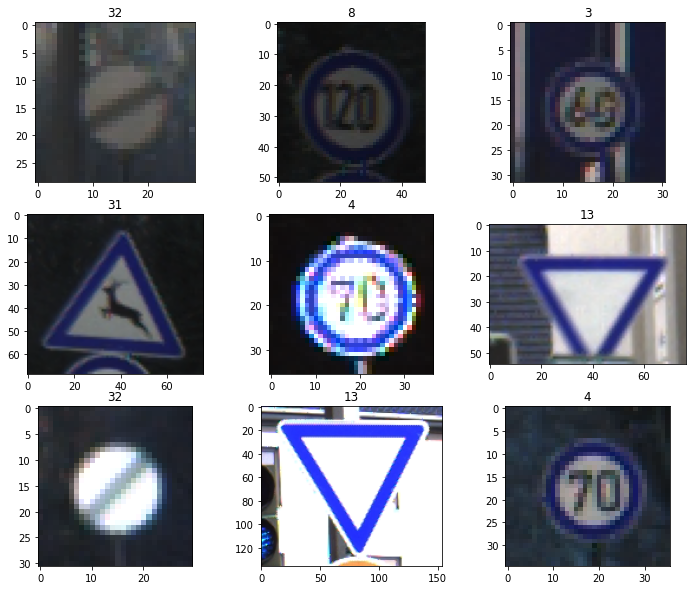

In [16]:
# visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [17]:
# Create validation and train sets
df_val = train.groupby('LABEL', group_keys=False).apply(lambda grouped_subset : grouped_subset.sample(frac=0.3))
df_train = train.drop(df_val.index)
print(df_train.LABEL.value_counts())
print(df_val.LABEL.value_counts())

2     1575
1     1554
13    1512
12    1470
38    1449
10    1407
4     1386
5     1302
25    1050
9     1029
7     1008
3      987
8      987
11     924
35     840
18     840
17     777
31     546
14     546
33     482
15     441
26     420
28     378
23     357
30     315
34     294
6      294
16     294
22     273
36     273
40     252
20     252
21     231
39     210
24     189
29     189
42     168
41     168
27     168
32     168
37     147
19     147
0      147
Name: LABEL, dtype: int64
2     675
1     666
13    648
12    630
38    621
10    603
4     594
5     558
25    450
9     441
7     432
3     423
8     423
11    396
35    360
18    360
17    333
31    234
14    234
33    207
15    189
26    180
28    162
23    153
30    135
34    126
6     126
16    126
22    117
36    117
40    108
20    108
21     99
39     90
24     81
29     81
42     72
41     72
27     72
32     72
37     63
19     63
0      63
Name: LABEL, dtype: int64


In [18]:
#data generators
batch_size = 32  
image_size = (224, 224)
learning_rate = 0.0001

train_steps = np.ceil(len(df_train) / batch_size)
val_steps = np.ceil(len(df_val) / batch_size )

classes = train.LABEL.unique().tolist()

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,
                             vertical_flip=True,shear_range=10,zoom_range=0.2,width_shift_range=0.1,
                             height_shift_range=0.1,channel_shift_range=10.)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_dataframe(df_train,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=True, seed=SEED)

val_ds = val_datagen.flow_from_dataframe(df_val,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=False, seed=SEED)

test_ds = val_datagen.flow_from_dataframe(test, x_col='filepath',target_size=image_size, class_mode=None,
                                          shuffle=False,batch_size=batch_size)#set shuffle=False for test dataset not be shuffled

Found 27446 validated image filenames belonging to 43 classes.
Found 11763 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames.


### 4. Model building

In [19]:
#we will use transfer learning from VGG16 model

def BuildModel (pretrained=VGG16):

    base_model = pretrained(include_top=False, weights='imagenet', input_shape=(224, 224,3)) #include_top=False to remove the last layer 

    for layer in base_model.layers:
        layer.trainable = False   #freeze trainable layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(3072, activation='relu', )(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(43, activation='softmax')(x) 
    
    model = Model(base_model.input, output)
    
    return model

In [20]:
model = BuildModel()

58892288/58889256 [==============================] - 0s 0us/step


In [21]:
#compile model
optimizer = keras.optimizers.Adam(lr=learning_rate) # Adam optmizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [22]:
#callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) # to prevent overfitting
chkpt_path = os.path.join("/content/drive/My Drive/models/", f"tb_model.h5", ) # path to save the model
checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)

In [23]:
#fit model
history = model.fit(train_ds, epochs=15,steps_per_epoch=train_steps, callbacks=[earlystop, checkpoint],
                    verbose=1, shuffle=False,validation_data=(val_ds), validation_steps= val_steps)

Epoch 1/15
858/858 [==============================] - ETA: 0s - loss: 2.1257 - auc: 0.9126
Epoch 00001: val_loss improved from inf to 1.35997, saving model to /content/drive/My Drive/models/tb_model.h5
858/858 [==============================] - 407s 474ms/step - loss: 2.1257 - auc: 0.9126 - val_loss: 1.3600 - val_auc: 0.9710
Epoch 2/15
858/858 [==============================] - ETA: 0s - loss: 1.4192 - auc: 0.9647
Epoch 00002: val_loss improved from 1.35997 to 1.15545, saving model to /content/drive/My Drive/models/tb_model.h5
858/858 [==============================] - 401s 468ms/step - loss: 1.4192 - auc: 0.9647 - val_loss: 1.1555 - val_auc: 0.9777
Epoch 3/15
858/858 [==============================] - ETA: 0s - loss: 1.2685 - auc: 0.9719
Epoch 00003: val_loss improved from 1.15545 to 1.00126, saving model to /content/drive/My Drive/models/tb_model.h5
858/858 [==============================] - 401s 467ms/step - loss: 1.2685 - auc: 0.9719 - val_loss: 1.0013 - val_auc: 0.9843
Epoch 4/15


### 5. Submission

In [24]:
#make predictions on test data
predictions = model.predict(test_ds)

In [25]:
submission = pd.DataFrame()
submission['ID'] = test['filepath']
submission['LABEL'] = np.argmax(predictions, axis=1) 

In [26]:
submission

,ID,LABEL
0,Test/00000.png,8
1,Test/00001.png,1
2,Test/00002.png,32
3,Test/00003.png,35
4,Test/00004.png,3
...,...,...
12625,Test/12625.png,4
12626,Test/12626.png,27
12627,Test/12627.png,41
12628,Test/12628.png,34


The project was a success and transfer learning performed well for the task. Depedning on the problem at hand, other architectures that can be used include ResNet and Inception.